In [281]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data  

In [282]:
close_df = pd.read_csv("ochlv_csv/코스닥/Close.csv", index_col=0)
close_df.index = pd.DatetimeIndex(close_df.index)

In [283]:
MA5 = close_df.rolling(5).mean().dropna(how="all",axis=0)
MA10 = close_df.rolling(10).mean().dropna(how="all",axis=0)

In [284]:
rebalance_date = pd.bdate_range(close_df.index[0], close_df.index[-1], freq="1W-Thu")
rebalance_date = list(set(MA5.index).intersection(set(rebalance_date)))
rebalance_date.sort()
rebalance_df = close_df.loc[rebalance_date]

ma5_signal = pd.DataFrame(index=rebalance_df.index, columns=rebalance_df.columns)
for i in rebalance_df.index:
    ma5_signal.loc[i][rebalance_df.loc[i][rebalance_df.loc[i] > MA5.loc[i]].index] = 1    

In [285]:
rebalance_date = pd.bdate_range(close_df.index[0], close_df.index[-1], freq="1W-Thu")
rebalance_date = list(set(MA10.index).intersection(set(rebalance_date)))
rebalance_date.sort()
rebalance_df = close_df.loc[rebalance_date]

buy_signal_df = pd.DataFrame(index=rebalance_df.index, columns=rebalance_df.columns)
for i in rebalance_df.index:
    buy_signal_df.loc[i][rebalance_df.loc[i][rebalance_df.loc[i] > MA10.loc[i]].index] = 1   

In [287]:
signal_df = buy_signal_df + ma5_signal
for i in signal_df.index:
    signal_df.loc[i][signal_df.loc[i] > 0] = "Buy"
    
signal_df = signal_df.fillna(0).reindex(close_df.index).ffill()
signal_df.to_csv("ochlv_csv/시그널/signal.csv")

In [288]:
daily_rtn = close_df.pct_change()
shifted_rtn = daily_rtn.shift(-1)

In [309]:
portfolio_df = pd.DataFrame(index=signal_df.index, columns=["Mean"])
portfolio_df["Mean"] = 0

for i in signal_df.index:
    portfolio_df["Mean"].loc[i] = (shifted_rtn.loc[i][signal_df.loc[i][signal_df.loc[i] == "Buy"].index]).mean()
    
portfolio_df.dropna()

,Mean
date,
2019-06-27,-0.004827
2019-06-28,-0.005799
2019-07-01,0.006866
2019-07-02,0.001548
2019-07-03,0.001707
...,...
2021-11-05,0.004773
2021-11-08,0.006089
2021-11-09,-0.020044


In [290]:
kosdaq = data.DataReader("^KQ11", "yahoo") 
kosdaq.index = pd.DatetimeIndex(kosdaq.index)
kosdaq = kosdaq["Close"]["20190612":].pct_change()

<AxesSubplot:>

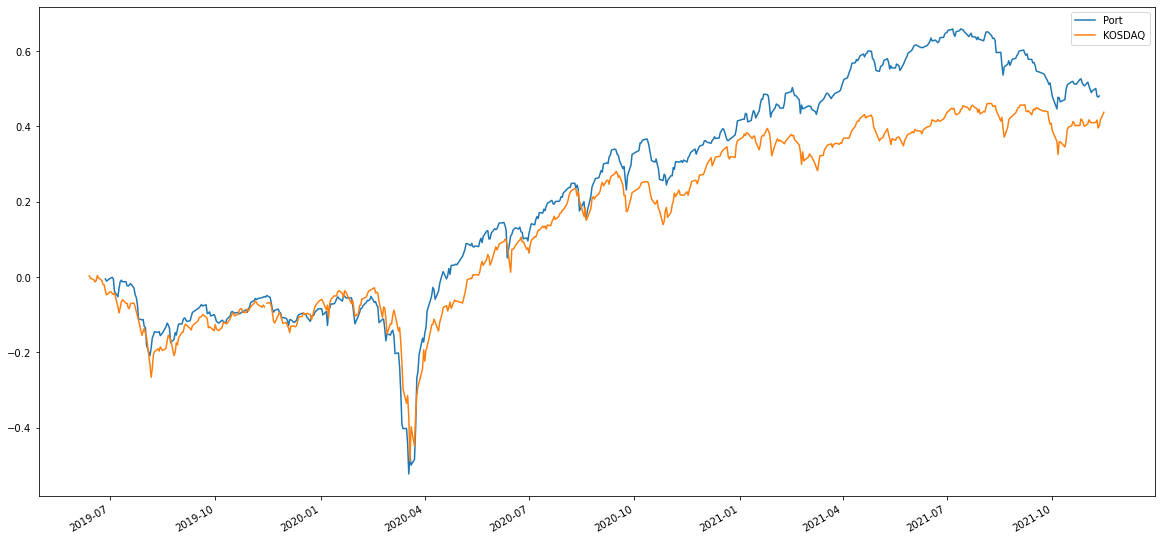

In [306]:
corr_df = pd.concat([portfolio_df["Mean"], kosdaq],axis=1)
corr_df.columns = ["Port", "KOSDAQ"]
corr_df.cumsum().plot(figsize=(20,10))

In [307]:
corr_df.corr()

,Port,KOSDAQ
Port,1.000000,0.221936
KOSDAQ,0.221936,1.000000
